# 3D Mnist - machine learning project

Author: Mateusz Sabuk

## Imports

In [24]:
import h5py
import pickle

import time

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Functions

- create_model(variables) -> model
- train_model(model, variables) -> training_history
- plot_model(model, training_history, model_name): saves plots at ./output/
- display_3d_vector(data): displays interactive 3D scatterplot of a 16x16x16 vector
- save_data_to_file(data, data_name="data"): saves data to file at ./output/
- get_data_from_file(data_name="data"): -> data from pkl file at ./output/

In [25]:
def create_model(variables):
    model = Sequential()

    model.add(Input(shape=(16, 16, 16, 1)))

    # Create convolutional layers
    for filter_num, kernel_size, pool_size in zip(variables["filters"], variables["kernel_sizes"], variables["pool_sizes"]):
        model.add(Conv3D(filters=filter_num, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=pool_size, padding='same'))

    # Flatten the output from the convolutional layers
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(units=variables["dense"], activation='relu'))
    model.add(Dropout(variables["dropout"]))  # Adding dropout for regularization

    # Output layer
    model.add(Dense(units=10, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=variables["learning_rate"]), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def train_model(model, variables):
    return model.fit(X_train, y_train, epochs=variables["epochs"], batch_size=variables["batch_size"], validation_data=(X_test, y_test))

def plot_model(model, training_history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(8, 6))
    plt.plot(training_history.history['accuracy'])
    plt.plot(training_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'])
    plt.savefig(f'output/{model_name}_accuracy.png', bbox_inches='tight')

    # Plot training & validation loss values
    plt.figure(figsize=(8, 6))
    plt.plot(training_history.history['loss'])
    plt.plot(training_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'])
    plt.savefig(f'output/{model_name}_loss.png', bbox_inches='tight')

    # Predict the classes on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap=plt.cm.Reds)
    plt.savefig(f'output/{model_name}_cm.png', bbox_inches='tight')

def display_3d_vector(data):
    data = data.reshape(16,16,16)
    
    x, y, z = np.indices(data.shape)
    values = data.flatten()
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    values = [f"rgba(20, 201, 129,{x})" for x in values]

    fig = go.Figure(data=go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=4,
            color=values,
            colorbar=dict(title='Value')
        )
    ))

    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis'
        )
    )
    fig['layout']['showlegend'] = False
    fig.show()


def save_data_to_file(data, data_name="data"):
    with open(f'output/{data_name}.pkl', 'wb') as f:
        pickle.dump(data, f)

def get_data_from_file(data_name="data"):
    with (open(f"output/{data_name}.pkl", "rb")) as f:
        data = pickle.load(f)
    return data

### Unused ones

I wanted to save the models with checkpoints but it was not really the part of the project

In [26]:
# def show_available_models():
#     matching_filenames = []
#     for filename in os.listdir('models/'):
#         if filename.endswith(f".h5"):
#             matching_filenames.append(filename)

#     for filename in matching_filenames:
#         # Access the metadata
#         with h5py.File(filename, 'r') as f:
#             if 'metadata' in f:
#                 metadata = f['metadata'].attrs
#                 variables = metadata.get('variables', '')
#                 print(f'File: {filename}')
#                 print(f'Used variables: {variables}')


# def get_model_from_file(model_name):
#     return load_model(f"models/{model_name}.h5")


# def save_model_to_file(model_name, variables):
#     # Load the best model
#     model = load_model(f'models/{model_name}.keras')

#     # Save the model again with additional metadata
#     model_save_path = f'models/{model_name}.h5'
#     model.save(model_save_path)

#     # Open the saved model file to add metadata
#     with h5py.File(model_save_path, 'a') as f:
#         # Create a group for metadata
#         metadata_group = f.create_group('metadata')
#         # Add descriptions or any other metadata
#         metadata_group.attrs['variables'] = variables

## Get data from h5 file

In [27]:
with h5py.File("data/full_dataset_vectors.h5", "r") as hf:
    X_train_vec = hf["X_train"][:]
    y_train = hf["y_train"][:]
    X_test_vec = hf["X_test"][:]
    y_test = hf["y_test"][:]

X_train_vec.shape, y_train.shape, X_test_vec.shape, y_test.shape

((10000, 4096), (10000,), (2000, 4096), (2000,))

### Reshape from 4096 vectors to 16x16x16 with 1 channel

In [28]:
X_train = X_train_vec.reshape(-1, 16, 16, 16)
X_test = X_test_vec.reshape(-1, 16, 16, 16)

X_train.shape, X_test.shape

((10000, 16, 16, 16), (2000, 16, 16, 16))

## Display a single vector of data

In [29]:
display_3d_vector(X_test[2])

## Model variables

variables example:
```python3
model_variables = {
    # Convolutional layers
    "filters": [32, 64, 128],
    "kernel_sizes": [2, 2, 2],
    "pool_sizes": [2, 2, 2],
    # Rest of the model
    "dense": 512,
    "dropout": 0.3,
    "learning_rate": 0.01,
    # Model training
    "epochs": 20,
    "batch_size": 32,
}
```

In [21]:
variables_array = [
    # Set 1
    {
        "filters": [16, 32, 64],
        "kernel_sizes": [3, 3, 3],
        "pool_sizes": [2, 2, 2],
        "dense": 256,
        "dropout": 0.5,
        "learning_rate": 0.001,
        "epochs": 25,
        "batch_size": 64,
    },
    # Set 2
    {
        "filters": [64, 128, 256],
        "kernel_sizes": [3, 3, 3],
        "pool_sizes": [2, 2, 2],
        "dense": 1024,
        "dropout": 0.4,
        "learning_rate": 0.0005,
        "epochs": 30,
        "batch_size": 32,
    },
    # Set 3
    {
        "filters": [32, 64, 128, 256],
        "kernel_sizes": [3, 3, 3, 3],
        "pool_sizes": [2, 2, 2, 2],
        "dense": 512,
        "dropout": 0.2,
        "learning_rate": 0.01,
        "epochs": 20,
        "batch_size": 32,
    },
    # Set 4
    {
        "filters": [128, 256],
        "kernel_sizes": [3, 3],
        "pool_sizes": [2, 2],
        "dense": 512,
        "dropout": 0.3,
        "learning_rate": 0.001,
        "epochs": 15,
        "batch_size": 64,
    },
    # Set 5
    {
        "filters": [32, 64, 64, 32],
        "kernel_sizes": [2, 2, 2, 2],
        "pool_sizes": [2, 2, 2, 2],
        "dense": 256,
        "dropout": 0.5,
        "learning_rate": 0.0001,
        "epochs": 20,
        "batch_size": 32,
    },
    # Set 6
    {
        "filters": [64, 64, 128, 128],
        "kernel_sizes": [3, 3, 3, 3],
        "pool_sizes": [2, 2, 2, 2],
        "dense": 1024,
        "dropout": 0.4,
        "learning_rate": 0.0001,
        "epochs": 25,
        "batch_size": 64,
    },
    # Set 7
    {
        "filters": [16, 32, 64, 128],
        "kernel_sizes": [2, 2, 2, 2],
        "pool_sizes": [2, 2, 2, 2],
        "dense": 256,
        "dropout": 0.3,
        "learning_rate": 0.01,
        "epochs": 30,
        "batch_size": 32,
    },
    # Set 8
    {
        "filters": [64, 128, 64],
        "kernel_sizes": [2, 2, 2],
        "pool_sizes": [2, 2, 2],
        "dense": 512,
        "dropout": 0.4,
        "learning_rate": 0.001,
        "epochs": 20,
        "batch_size": 64,
    },
    # Set 9
    {
        "filters": [128, 64, 32],
        "kernel_sizes": [3, 3, 3],
        "pool_sizes": [2, 2, 2],
        "dense": 1024,
        "dropout": 0.3,
        "learning_rate": 0.005,
        "epochs": 25,
        "batch_size": 32,
    },
    # Set 10
    {
        "filters": [32, 32, 32, 32],
        "kernel_sizes": [3, 3, 3, 3],
        "pool_sizes": [2, 2, 2, 2],
        "dense": 512,
        "dropout": 0.4,
        "learning_rate": 0.0005,
        "epochs": 20,
        "batch_size": 32,
    },
    # Set 11
    {
        "filters": [64, 128, 256, 512],
        "kernel_sizes": [3, 3, 3, 3],
        "pool_sizes": [2, 2, 2, 2],
        "dense": 1024,
        "dropout": 0.3,
        "learning_rate": 0.0001,
        "epochs": 30,
        "batch_size": 64,
    },
    # Set 12
    {
        "filters": [16, 32, 64],
        "kernel_sizes": [2, 2, 2],
        "pool_sizes": [2, 2, 2],
        "dense": 256,
        "dropout": 0.2,
        "learning_rate": 0.01,
        "epochs": 25,
        "batch_size": 64,
    },
    # Set 13
    {
        "filters": [32, 64, 128, 256],
        "kernel_sizes": [2, 2, 2, 2],
        "pool_sizes": [2, 2, 2, 2],
        "dense": 512,
        "dropout": 0.5,
        "learning_rate": 0.0005,
        "epochs": 20,
        "batch_size": 32,
    },
    # Set 14
    {
        "filters": [64, 128, 256],
        "kernel_sizes": [3, 3, 3],
        "pool_sizes": [2, 2, 2],
        "dense": 1024,
        "dropout": 0.3,
        "learning_rate": 0.001,
        "epochs": 30,
        "batch_size": 64,
    },
    # Set 15
    {
        "filters": [32, 64, 32],
        "kernel_sizes": [2, 2, 2],
        "pool_sizes": [2, 2, 2],
        "dense": 256,
        "dropout": 0.4,
        "learning_rate": 0.005,
        "epochs": 25,
        "batch_size": 32,
    },
    # Set 16
    {
        "filters": [128, 256, 512],
        "kernel_sizes": [3, 3, 3],
        "pool_sizes": [2, 2, 2],
        "dense": 1024,
        "dropout": 0.3,
        "learning_rate": 0.0001,
        "epochs": 20,
        "batch_size": 64,
    },
]


## Train the network

In [ ]:
data = []
for i, variables in enumerate(variables_array):
    try:
        model = create_model(variables)
        start = time.time()
        training_history = train_model(model, variables)
        end = time.time()
        plot_model(model, training_history, str(i).zfill(2))

        data.append({
            "variables": variables,
            "time": end-start, 
            "accuracy": training_history.history['accuracy'],
            "val_accuracy": training_history.history['val_accuracy'],
            "loss": training_history.history['loss'],
            "val_loss": training_history.history['val_loss']})
    except Exception as e:
        print(e)
        data.append(f"Model nr {str(i).zfill(2)} error: {e}")
    save_data_to_file(data)

## Create plots from collected data

### Get data

In [31]:
data = get_data_from_file()
len(data)

16

### Line plots

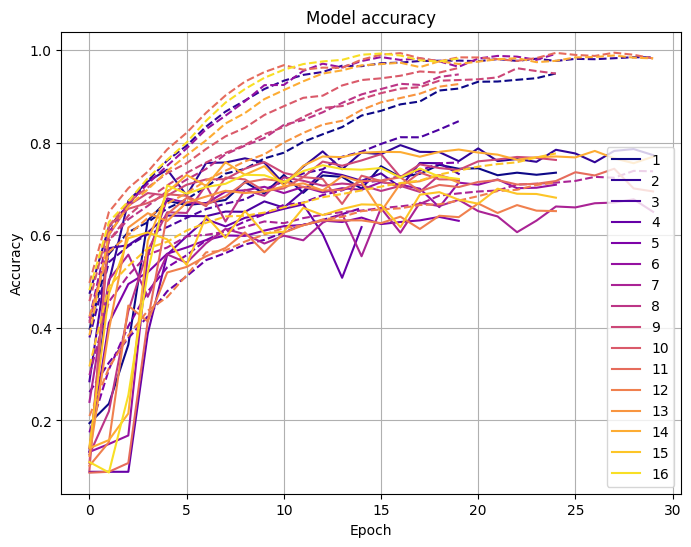

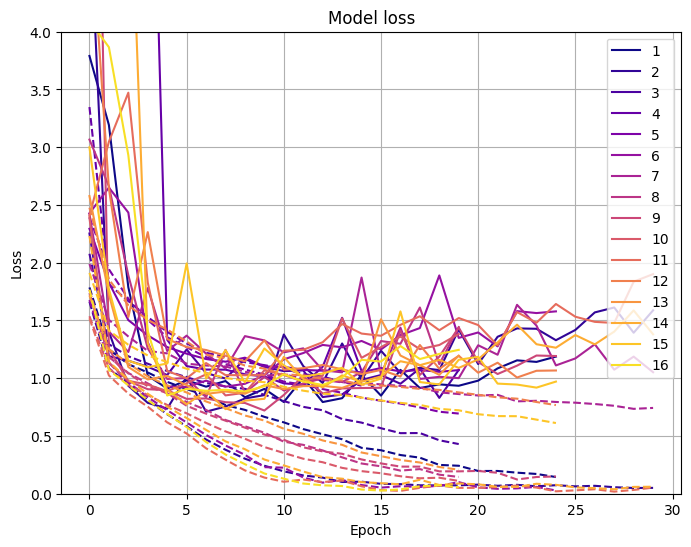

In [32]:
plots_name = "batch_gpt"

colormap = plt.get_cmap('plasma')
num_colors = len(data)

plt.figure(figsize=(8, 6))
for i, model in enumerate(data):
    color = colormap(i / num_colors)
    plt.plot(model["accuracy"], "--", color=color)
    plt.plot(model["val_accuracy"], color=color, label=f"{i+1}")
plt.grid()
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(f'output/{plots_name}_accuracy.png', bbox_inches='tight')

plt.figure(figsize=(8, 6))
for i, model in enumerate(data):
    color = colormap(i / num_colors)
    plt.plot(model["loss"], "--", color=color)
    plt.plot(model["val_loss"], color=color, label=f"{i+1}")
plt.grid()
ax = plt.gca()
ax.set_ylim([0, 4])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(f'output/{plots_name}_loss.png', bbox_inches='tight')

### Bar plots

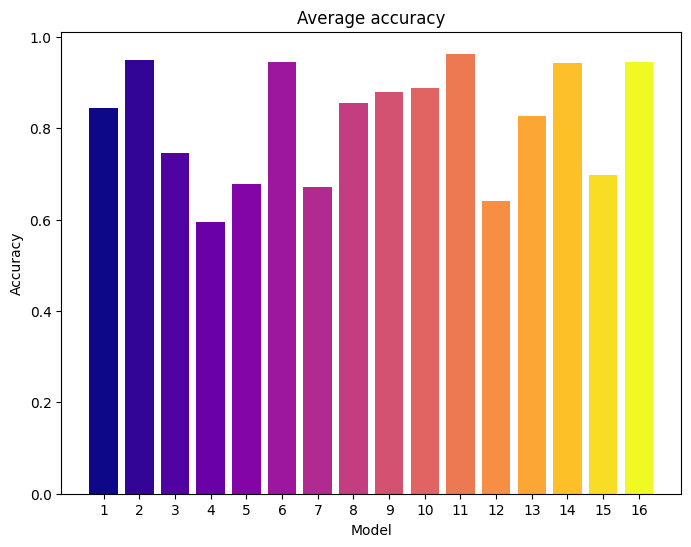

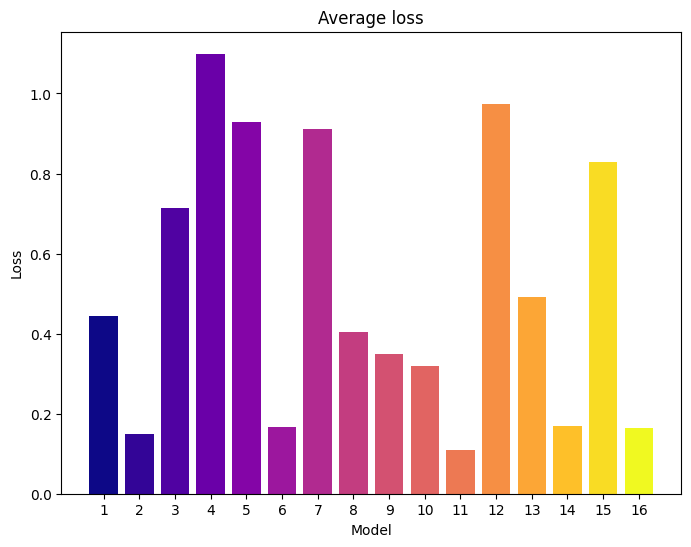

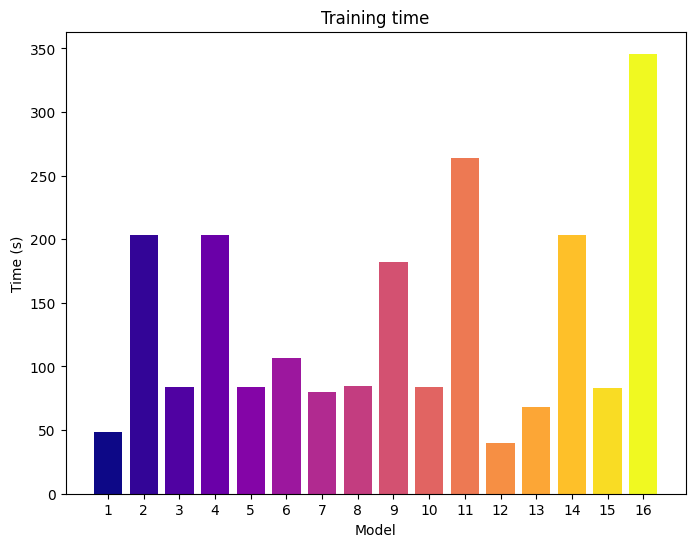

<Figure size 800x600 with 0 Axes>

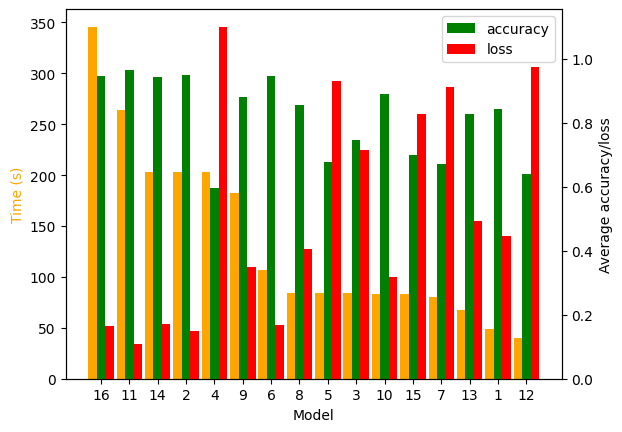

In [33]:
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
avg = lambda x: sum(x) / len(x)

x = [x+1 for x in [*range(len(data))]]
accuracy_y = [avg(x["accuracy"][5:]) for x in data]

my_cmap = plt.get_cmap("plasma")
plt.figure(figsize=(8, 6))
plt.bar(x, accuracy_y, color=my_cmap(rescale(x)))
plt.title('Average accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(np.arange(1,len(data)+1), np.arange(1,len(data)+1))
plt.savefig(f'output/{plots_name}_avg_accuracy.png', bbox_inches='tight')

loss_y = [avg(x["loss"][5:]) for x in data]

plt.figure(figsize=(8, 6))
plt.bar(x, loss_y, color=my_cmap(rescale(x)))
plt.title('Average loss')
plt.ylabel('Loss')
plt.xlabel('Model')
plt.xticks(np.arange(1,len(data)+1), np.arange(1,len(data)+1))
plt.savefig(f'output/{plots_name}_avg_loss.png', bbox_inches='tight')

time_y = [x["time"] for x in data]

plt.figure(figsize=(8, 6))
plt.bar(x, time_y, color=my_cmap(rescale(x)))
plt.title('Training time')
plt.ylabel('Time (s)')
plt.xlabel('Model')
plt.xticks(np.arange(1,len(data)+1), np.arange(1,len(data)+1))
plt.savefig(f'output/{plots_name}_training_time.png', bbox_inches='tight')

zipped_model = list(zip(x, accuracy_y, loss_y, time_y))
sorted_model = reversed(sorted(zipped_model, key = lambda t: t[3]))
sorted_x, sorted_accuracy_y, sorted_loss_y, sorted_time_y = zip(*sorted_model)

plt.figure(figsize=(8, 6))
width = 0.3
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar([x+0.7 for x in [*range(len(data))]], sorted_time_y, width, color='orange', label='time') 
ax2.bar([x+1 for x in [*range(len(data))]], sorted_accuracy_y, width, color='green', label='accuracy') 
ax2.bar([x+1.3 for x in [*range(len(data))]], sorted_loss_y, width, color='red', label='loss') 

ax1.set_xlabel('Model')
ax1.set_ylabel('Time (s)', color="orange")
ax2.set_ylabel('Average accuracy/loss')

plt.xticks(np.arange(1,len(data)+1), sorted_x)
plt.legend()
plt.savefig(f'output/{plots_name}_bars_grouped.png', bbox_inches='tight')